# Bulk analysis of constant velocity experiments
In this notebook we take a large number of constant velocity traces and inspect each of them for:
- Unfolding events
- Experimental errors
  - Multiple tethers
  - Bead loss

After which we determine the contour lengths of unfolded domains as well as their unfolding forces, by fitting each curve with Odijk and Marko-Siggia models (for DNA handles and unfolded protein respectively).

This is very much a work in progress and there are some things to keep in mind (also a todo/fix list):
- For now, fdcurves have to include both the pulling and relaxation parts, even if we only care about the pull.
- The error-finding capabilities are not yet proven to be effective.
- There is no error-handling and limited sanity-checking: the notebook can fail silently and in unexpected ways.

In [1]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

from curve import Curve

## Defining models

Here we define our models. As long as the below estimates correspond, you should be able to change these. The name strings (```'handles'``` and ```'protein'```) feature as part of parameter names and these should stay consistent.

In [2]:
# these dont have to be build functions anymore, can just be model objects
def build_handles_model():
    return lk.inverted_odijk('handles') + lk.force_offset('handles')
def build_composite_model():
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    return comp_wrt_f.invert(interpolate = True, 
                             independent_min = 0,
                             independent_max = 90) + lk.force_offset('handles')

## Providing estimates

Here we provide some initial guesses for the model parameters in a dictionary format.

For each parameter, the possible entries are ```'value'```, ```'upper_bound'```, ```'lower_bound'``` and ```'fixed'```, where the latter fixes the parameter value to that in the 'value' field.

In [3]:
from build_config import bp2cl

handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 10},
     'handles/Lc':  # contour length (um)
      {'value': 0.3},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 200},  # was 250 200 to 600 is acceptable
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': False}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }

### Above data gets ignored. Here we take a big trace and split it up into separate curves.

<KeysViewHDF5 ['1X', '1Y']>
<KeysViewHDF5 ['Calibration', 'Distance', 'Force HF', 'Marker', 'Trap position']>
[]
0 0
len 8284295
[0.92105231 0.92692575 0.93279919 0.93867263 0.94454606 0.9504195
 0.95629294 0.96216638 0.96803981 0.97391325 0.97978669 0.98566013
 0.99153356 0.997407   1.00328044 1.00915388 1.01502732 1.02090075
 1.02677419 1.03264763 1.03852107 1.0443945  1.05026794 1.05614138
 1.06201482 1.06788825 1.07376169 1.07963513 1.08550857 1.091382
 1.09725544 1.10312888 1.10900232 1.11487576 1.12074919 1.12662263
 1.13249607 1.13836951 1.14424294 1.15011638 1.15598982 1.16186326
 1.16773669 1.17361013 1.17948357 1.18535701 1.19123044 1.19710388
 1.20297732 1.20885076 1.21472419 1.22059763 1.22647107 1.23234451
 1.23821795 1.24409138 1.24996482 1.25583826 1.2617117  1.26758513
 1.27345857 1.27933201 1.28520545 1.29107888 1.29695232 1.30282576
 1.3086992  1.31457263 1.32044607 1.32631951 1.33219295 1.33806638
 1.34393982 1.34981326 1.3556867  1.36156014 1.36743357 1.37330701
 1.

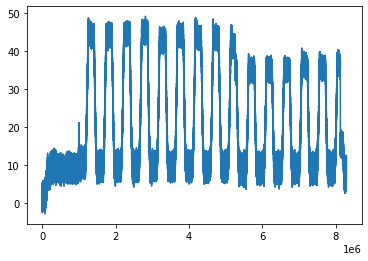

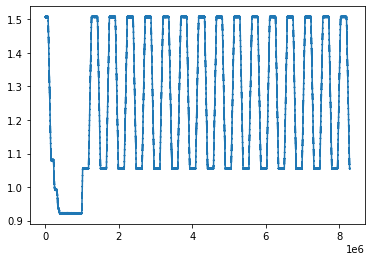

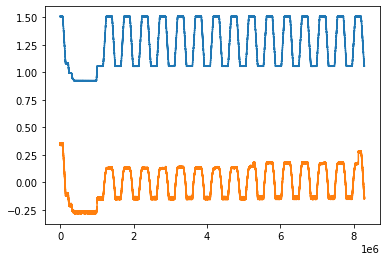

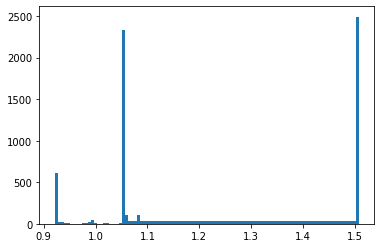

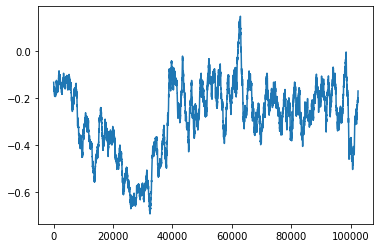

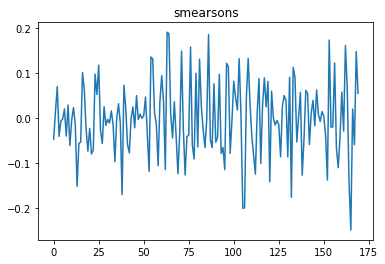

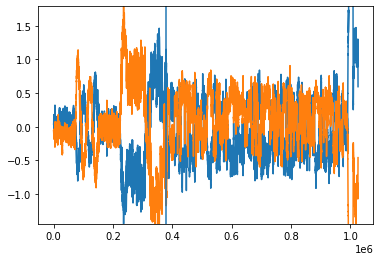

In [4]:
import h5py
from autosplit import autosplit
fle = h5py.File('/home/kris/proj/.data/tweez/2004/mark2.h5')
plt.plot(fle['Force HF']['Force 1x'][:])
plt.figure()
plt.plot(fle['Trap position']['1X'][:])

print(fle['Trap position'].keys())
print(fle.keys())
ditch_guess = 0.0
#test_curves = autosplit('/home/kris/proj/.data/tweez/yhsp2.h5')
test_curves = autosplit('/home/kris/proj/.data/tweez/2004/mark2.h5')
print(test_curves.keys())
for curve in test_curves.values():
    curve['pull_dist'] -= ditch_guess
    #min_force = min(curve['full_force'])
    min_force = 0
    curve['pull_force'] -= min_force
print(test_curves['curve_03']['pull_dist'])
test_curves.pop('curve_10')

fdcurves = {}  # clear fdcurces
for key, curve in test_curves.items():
    fdcurves[key] = Curve(key, *[curve[dname]
                                for dname in ['full_dist', 'full_force',
                                              'pull_dist', 'pull_force',
                                              'rlx_dist', 'rlx_force']])

In [5]:
print(len(fdcurves.items()))
print(fdcurves.keys())
fdcurves.pop('curve_17')

14
dict_keys(['curve_01', 'curve_02', 'curve_03', 'curve_04', 'curve_05', 'curve_06', 'curve_07', 'curve_08', 'curve_09', 'curve_11', 'curve_12', 'curve_13', 'curve_14', 'curve_15'])


KeyError: 'curve_17'

## Bead loss errors
Data featuring force suddenly dropping to zero can dramatically slow down the event-finding and fitting steps, so we filter those out first. Other error-finding operations depend on the events found below and will happen later.

In [6]:
lost_bead_fdcurves = {}
for curve_id, curve in fdcurves.items():
    #plt.plot(curve.dist_data)
    #plt.title(curve_id)
    #plt.show()
    if curve.filter_bead_loss(handle_contour = handle_estimates['handles/Lc']['value']):
        lost_bead_fdcurves[curve_id] = curve
for curve_id in lost_bead_fdcurves.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

## Event-finding
Here we try to find unfolding events, stationary/turning points and start-points. Unfolding events are recognized through a sharp dip in the force over time graph, and stationary/turning points by a sharp dip in the force's local variance. Start-points are determined by where the system's force first exceeds the ```STARTING_FORCE``` argument of the find_events function, which defaults to 0.

Curves are then split into 'legs' of datapoints between events, and those legs are used to fit our different models. The ```SHOW_PLOTS``` option produces a plot for each curve, showing the different events and legs.

Further (optional) arguments for the ```find_events``` function are:
- ```CORDON```, which determines how many datapoints directly before and after an event we exclude from fitting. Defaults to 10,
- ```FIT_ON_RETURN```, describes which part of the relaxation curve we mark for fitting. Defaults to an empty tuple, ignoring the relaxation curve. Valid input is a tuple like ```(WHEN, NUMBER)``` indicating how far after the return point to start fitting, and how many points to include.

```SHOW_PLOTS``` determines whether to show plots highlighting the different events and legs for each curve.

curve_01
curve_01
curve_02
curve_02
curve_03
curve_03
curve_04
curve_04
curve_05
curve_05
curve_06
curve_06
curve_07
curve_07
curve_08
curve_08
curve_09
curve_09
curve_11
curve_11
curve_12
curve_12
curve_13
curve_13
curve_14
curve_14
curve_15
curve_15


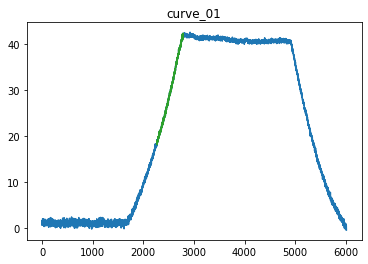

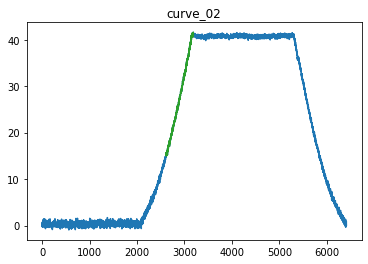

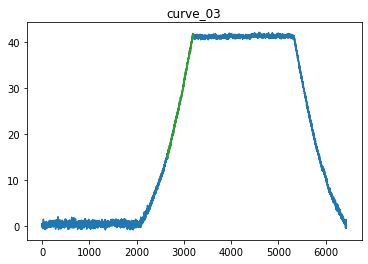

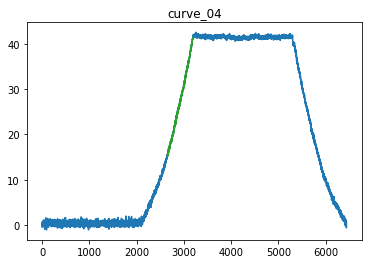

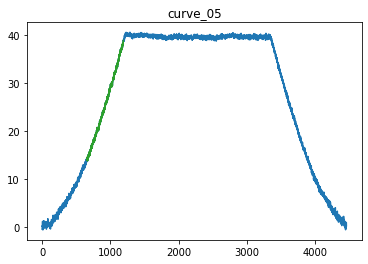

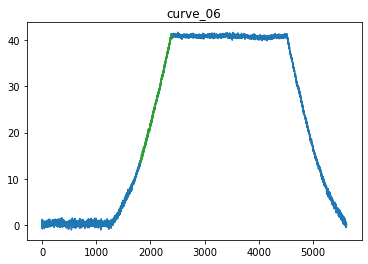

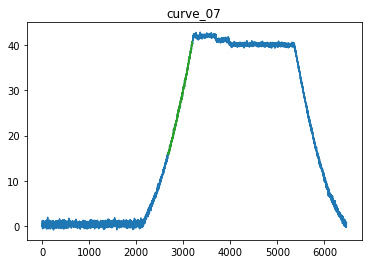

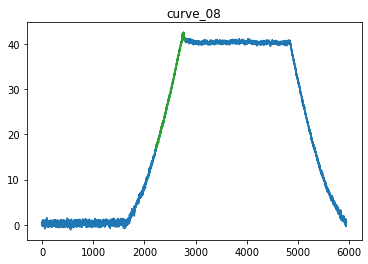

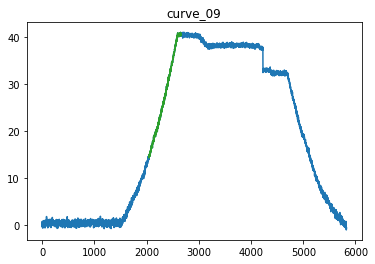

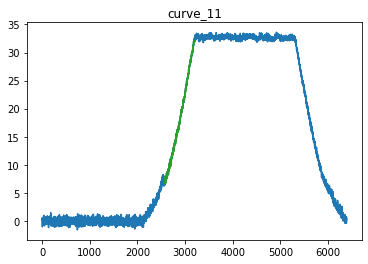

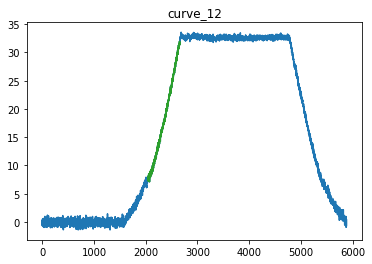

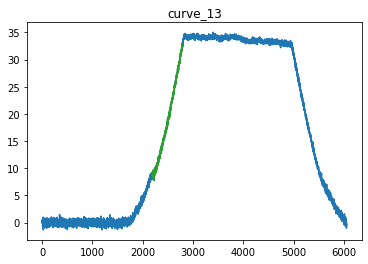

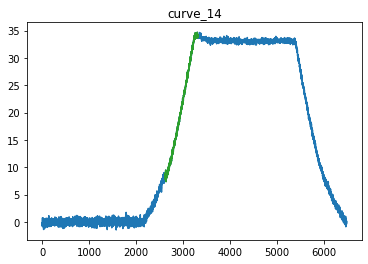

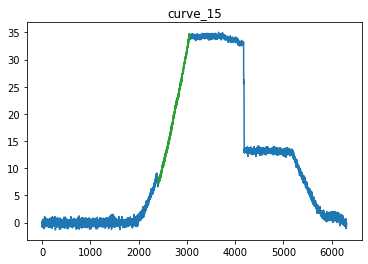

In [7]:
SHOW_PLOTS = True
%matplotlib inline

for curve in fdcurves.values():
    print(curve.identifier)
    curve.find_events(DEBUG=True, handle_contour = handle_estimates['handles/Lc']['value'])
    #print(curve.top)
    if SHOW_PLOTS:
        curve.plot_events()
# plot force over time (or number of measurements)
# green: fitted leg, orange: unfold event, red: return/stationary point


In [8]:
no_unfolds = {}
for curve_id, curve in fdcurves.items():
    if not curve.unfolds.any(): #or not curve_id == 'split_curve9':
        no_unfolds[curve_id] = curve  
for curve_id in no_unfolds.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

curve_01
curve_02
curve_03
curve_04
curve_05
curve_06
curve_07
curve_08
curve_09
curve_11
curve_12
curve_13
curve_14
curve_15


In [9]:
for curve_id, curve in fdcurves.items():
    print(curve_id)
    #print(curve.top)
    print(curve.unfolds)

## Error-finding
##### Multiple tethers
We filter multiple tethers comparison of the model as given in the estimates, with exaggerated parameters or data. The tests we perform include:
- A doubled persistence length
- A halved contour length
- Halved force data
- Doubled distance data

These should in theory test the single-tether case against the double-tether case. For a greater number of tethers we assume a double-tether model would fit better than a single-tether one. We compare the resulting BICs to determine pass or fail. We also compute Bayes factors for relative likelihood comparisons, but those turn out rather extreme.

Doubling the persistence length yields false positives and does not seem to be a good way to approximate a double tether. Some higher factor would probably work but for now we can just ignore that test.

We may want to hide some of this code behind an import

Halving contour length appears functionally identical to doubling the distance data, so we can do away with one.

In [10]:
from copy import deepcopy

original = handle_estimates
double_Lp = deepcopy(original)
half_Lc = deepcopy(original)
double_Lp['handles/Lp']['value'] = original['handles/Lp']['value'] * 2
half_Lc['handles/Lc']['value'] = original['handles/Lc']['value'] / 2

test_estimates = {'original': original, 'double_Lp': double_Lp, 
                  'half_Lc': half_Lc, 'half_force': original,
                  'double_dist': original}

for curve in fdcurves.values():
    print(curve.identifier)
    curve.filter_tethers(build_handles_model(), test_estimates)

## Fitting

Here we fit our models. We first define fits for each unfolding event, and proliferate a single fit of the DNA handles parameters to each of them. After that, we fit the remaining protein parameters with the legs we defined before. The third cell draws plots and shows parameter summaries for each curve.

In [11]:
for curve in fdcurves.values():
    print(curve.identifier, curve.legs)

In [12]:
#fdcurves.pop('split_curve4')
#fdcurves.pop('split_curve9')
#fdcurves.pop('split_curve5')

for curve in fdcurves.values():
    print(curve.identifier)
    curve.initialize_fits(build_handles_model(),
                         build_composite_model(),
                         handle_estimates)

In [13]:
# some fits may take a while. should finish though
for curve_id, curve in fdcurves.items():
    print(curve_id)
    curve.fit_composites(protein_estimates)

In [14]:
%matplotlib inline
for curve in fdcurves.values():
    curve.plot_fits()
    #plt.yscale('log')
    plt.show()
    curve.print_fit_params()

#### Computing unfolding forces
We compute the force for each unfolding event by simulating the fitted model to the distance slightly before the unfolding event. This part is lacking an error estimation.

In [15]:
for curve in fdcurves.values():
    curve.compute_unfold_forces(build_handles_model(), build_composite_model())

#### Result summary table
Prints a summary table containing fitted contour length, persistence length and unfolding force for each unfolding domain. Could be prettier

In [16]:
# score and/or rank by fit quality

# make a format string for the column widths
largest_id_len = max([len(id) for id in fdcurves.keys()])
row_format = f'{{:<{largest_id_len + 1}}}| {{:<5}}| {{:<9}}| {{:<9}}| {{:<9}}| {{}}'

print(row_format.format('Curve', 'fold', 'Lc (um)', 'Lp (nm)', 'Fu (pN)',
                        'failed tests'))
for curve_id, curve in fdcurves.items():
    curve.print_result_rows(row_format)

if lost_bead_fdcurves:
    print('\nBead losses for curves', [curve_id for curve_id in
                                       lost_bead_fdcurves.keys()])

ValueError: max() arg is an empty sequence

In [17]:
from event_finding import moving_window_SLR

In [18]:
models = moving_window_SLR(fdcurves['split_curve9'].force_data)

KeyError: 'split_curve9'

In [ ]:
models

In [ ]:
#print(vars(fdcurves['curve_12']))
ex_curve = fdcurves['curve_12']

fig, ax1 = plt.subplots()
ax1.plot(ex_curve.pull_f)
ax1.set_ylabel('Force (pN)', fontsize=18, color='tab:blue')
ax1.set_xlabel('Time')
ax2 = ax1.twinx()
ax2.plot(ex_curve.pull_d, c='tab:orange')
ax2.set_ylabel('Distance (um)', fontsize=18, color='tab:orange')

ax1.axvline(500,linestyle='--', c='tab:gray')
ax1.axvline(600,linestyle='--', c='tab:gray')
ax1.axvspan(500, 600, alpha=0.5, color='tab:gray')
ax1.axvline(1550,linestyle='--', c='tab:gray')

In [ ]:
slices = [slice(i * 100 , i * 100 + 100) for i in range(5,20)]
fit = lk.FdFit(build_handles_model())
fit.add_data('first', ex_curve.pull_f[slices[0]], ex_curve.pull_d[slices[0]])
from util import load_estimates, extract_estimates
load_estimates(fit, handle_estimates)
fit.fit()
print(vars(fit))
fit.plot()
fit.bic
bix = []
ests = extract_estimates(fit)
print(ests)
for slc in slices:
    tmpfit = lk.FdFit(build_handles_model())
    tmpfit.add_data('slice', ex_curve.pull_f[slc], ex_curve.pull_d[slc])
    load_estimates(tmpfit, ests)
    bix.append(tmpfit.bic)
plt.figure()
x = [i * 100 for i in range(5, 20)]
plt.plot(x,bix)

In [ ]:
datasets = [{'filename': '/home/kris/proj/.data/tweez/adk5_curve1.h5', 'curve_ids': ['adk5_curve1']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve2.h5', 'curve_ids': ['adk5_curve2']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve3.h5', 'curve_ids': ['adk5_curve3']}]
adkurves = {}
for dataset in datasets:
    data = lk.File(dataset['filename'])
    #print(data.fdcurves)
    for curve_id in dataset['curve_ids']:
        original = data.fdcurves[curve_id]
        fdata = data.fdcurves[curve_id].f.data
        ddata = data.fdcurves[curve_id].d.data
        if True:
            fdata = fdata[ddata > 0]
            ddata = ddata[ddata > 0]
        adkurves[curve_id] = Curve(curve_id, ddata, fdata)
        # we don't need the id in two different place

In [ ]:
ex_curve = adkurves['adk5_curve2']
plt.plot(ex_curve.force_data)
plt.axvline(1750)
print(np.argwhere(ex_curve.dist_data > 0.35)[0])
plt.plot(ex_curve.dist_data)
pull_force = ex_curve.force_data[:1750]
pull_dist = ex_curve.dist_data[:1750]


In [ ]:
#print(vars(fdcurves['curve_12']))
#ex_curve = fdcurves['curve_12']

fig, ax1 = plt.subplots()
ax1.plot(pull_force)
ax1.set_ylabel('Force (pN)', fontsize=18, color='tab:blue')
ax1.set_xlabel('Time')
ax2 = ax1.twinx()
ax2.plot(pull_dist, c='tab:orange')
ax2.set_ylabel('Distance (um)', fontsize=18, color='tab:orange')

ax1.axvline(800,linestyle='--', c='tab:gray')
ax1.axvline(900,linestyle='--', c='tab:gray')
ax1.axvspan(800, 900, alpha=0.1, color='tab:gray')
for i in range(10, 18):
    ax1.axvline(i * 100,linestyle='--', c='tab:gray')
    ax1.axvspan(800, i * 100, alpha=0.1, color='tab:gray')


In [ ]:
from util import load_estimates, extract_estimates, thresholding_algo
    
def compute_bic(force, dist, ests):
    fit = lk.FdFit(build_handles_model())
    fit.add_data('slice', force, dist)
    load_estimates(fit, ests)
    bic = fit.bic
    fit.fit()
    return (bic, extract_estimates(fit))


def group_continuous(indices):
    groups = [[indices[0][0]]] # np.argwhere returns array of single-element arrays
    current_group = 0
    for index in indices[1:]:
        index = index[0]
        if index == groups[current_group][-1] + 1:
            groups[current_group].append(index)
        else:
            groups.append([index])
            current_group += 1
    return groups


def stupid_interp(data, len_factor):
    interp_data = []
    for point in data:
        for replicate in range(len_factor):
            interp_data.append(point)
    return interp_data
    
    
def zoom_unfold(force, dist, first_index, almost_peak, end_peak):
    print(first_index, almost_peak, end_peak)
    ref_fit = lk.FdFit(build_handles_model())
    ref_fit.add_data('before', force[first_index:almost_peak], dist[first_index:almost_peak])
    ref_fit.fit()
    ests = extract_estimates(ref_fit)
    bix = []
    for index in range(almost_peak, end_peak):
        (bic, ests) = compute_bic(force[first_index:index], dist[first_index:index], ests)
        bix.append(bic)
    peaksign = thresholding_algo(np.diff(bix), len(bix)// 2, 4., 0)['signals']
    plt.plot(force)
    print('max dbic', np.argmax(np.diff(bix)))
    print(peaksign)
    plt.figure()
    plt.plot(np.diff(bix))
    return np.where(peaksign >= 1)[0] + almost_peak


def running_fit(force, dist, first_index, last_index, slice_width):
    slices = [slice(first_index, i * slice_width + slice_width) for i in range(first_index // slice_width,
                                                                              last_index // slice_width)]
    fit = lk.FdFit(build_handles_model())
    fit.add_data('first', force[slices[0]], dist[slices[0]])
    fit.fit()
    ests = extract_estimates(fit)
    bix = []
    for slc in slices: # /online/ peak-finding?
        (bic, ests) = compute_bic(force[slc], dist[slc], ests)
        bix.append(bic)
        
    peaksign = thresholding_algo(np.diff(bix), len(bix) // 3, 4., 0)['signals']
                                                    # these parameters are awkward
    peaksign = np.asarray(stupid_interp(peaksign, slice_width))
    grouped_peak_signals = group_continuous(np.argwhere(peaksign >= 1) + first_index)
    exact_unfolds = []
    for group in grouped_peak_signals:
        exact_unfolds.append(zoom_unfold(force, dist, first_index, group[0] - slice_width, group[-1]))
    print(exact_unfolds)
    return {'slices': slices, 'bix': bix, 
            'signals': peaksign, 'groups': grouped_peak_signals, 
            'unfolds': exact_unfolds}

asd = running_fit(pull_force, pull_dist, 800, 1700, 50)

plt.figure()
plt.plot(asd['bix'])
plt.plot(np.diff(asd['bix']))
plt.figure()
plt.plot(asd['signals'])
print(asd['groups'])
plt.figure()
plt.plot(pull_force)
plt.axvline(1491)
#plt.axvline(asd['groups'][0][0])
plt.axvline(asd['groups'][0][-1])
plt.figure()
groups = asd['groups']
#plt.plot(pull_force[slice(groups[0][0] + 10,groups[0][-1] + 10)])
plt.figure()
plt.plot(pull_force[1400:1600])
plt.axvline(110, c='tab:orange')
#print(running_fit(pull_force[1400:1600], pull_dist[1400:1600], 0, 200, 10))
from event_finding import find_transitions
find_transitions(pull_force[1400:1600])
plt.axvline(119, c='tab:green')

In [ ]:
slices = [slice(800 , i * 10 + 100) for i in range(80,170)]
fit = lk.FdFit(build_handles_model())
print(pull_force)
fit.add_data('first', pull_force[slices[0]], pull_dist[slices[0]])
from util import load_estimates, extract_estimates
load_estimates(fit, handle_estimates)
fit.fit()
print(vars(fit))
fit.plot()
fit.bic
bix = []
ests = extract_estimates(fit)
print(ests)
for slc in slices:
    tmpfit = lk.FdFit(build_handles_model())
    tmpfit.add_data('slice', pull_force[slc], pull_dist[slc])
    load_estimates(tmpfit, ests)
    bix.append(tmpfit.bic)
    #plt.figure()
    #tmpfit.plot()
    tmpfit.fit()
    ests = extract_estimates(tmpfit)
plt.figure()
x = [i * 10 for i in range(80, 170)]
fig, ax1 = plt.subplots()
ax1.plot(x,bix)
ax2 = ax1.twinx()
ax2.plot(x,np.log(bix), c='tab:orange')
#ax2.yscale('log')
plt.figure()
plt.plot(x,bix)
plt.ylabel('Model BIC', fontsize=18)
plt.figure()
plt.plot(np.diff(bix))
plt.ylabel(r'$\Delta$BIC', fontsize=18)


In [ ]:
from build_config import bp2cl

handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 10},
     'handles/Lc':  # contour length (um)
      {'value': 0.3},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 200},  # was 250 200 to 600 is acceptable
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': False}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }

In [ ]:
bp2cl(1040)

In [ ]:
from simulate import generate_fd
DEBUG = False

sim_curves = []
if DEBUG:
    # multiple unfold cases
    dist_unfold = 0.38
    clslist = [[0.025], [0.015, 0.030], [0.01, 0.02, 0.03]]
    for index, cls in enumerate(clslist):
        sim_curves[curve_id] = \
            Curve(curve_id, *generate_fd(dist_unfold, cls, handle_estimates, protein_estimates))
    # lost bead case
    dist, force = generate_fd(0.38, [0.025], handle_estimates, protein_estimates)
    force[1800:] = 0
    fdcurves['sim_loss'] = Curve('sim_loss', dist, force)

In [ ]:
sim_curve = [*generate_fd(0.38, [0.01, 0.02, 0.03], handle_estimates, protein_estimates)]

In [ ]:
plt.plot(sim_curve[1])
plt.axvline(1900)
rft = running_fit(sim_curve[1], sim_curve[0], 300, 1900, 10)
plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(np.diff(rft['bix']))
from util import thresholding_algo
thlg = thresholding_algo(np.diff(rft['bix']), len(rft['bix']) // 2, 4., 0)
ax2 = ax1.twinx()
ax2.plot(thlg['signals'], c='tab:orange')

In [ ]:
np.argwhere(thlg['signals'] >= 1)
def group_continuous(indices):
    groups = [[indices[0][0]]] # np.argwhere returns array of single-element arrays
    current_group = 0
    for index in indices[1:]:
        index = index[0]
        if index == groups[current_group][-1] + 1:
            groups[current_group].append(index)
        else:
            groups.append([index])
            current_group += 1
    return groups
group_continuous(np.argwhere(thlg['signals'] >= 1))

In [ ]:
np.argwhere(thlg['signals'] >= 1)[0][0]

In [ ]:
asd = running_fit(sim_curve[1], sim_curve[0], 300, 1900, 10)

In [ ]:
asd.keys()
asd['unfolds']